# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/ACV_Lab/')
path = '.'

#pwd

#ls

# IMPORT LIBRARIES AND PACKAGES

import csv
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.optimizers import Adam

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Change directory

In [5]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/ACV_Lab'

# New Section

### Load the training data from train.csv file

In [13]:
TRAIN_CSV = "/content/drive/My Drive/Colab Notebooks/ACV_Lab/train_labels.csv"
df = pd.read_csv('train_labels.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [14]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [15]:
IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224). MobileNetV2 can also take 96

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [26]:
path = '/content/drive/My Drive/Colab Notebooks/ACV_Lab/images'
mylist  = os.listdir(path)
print(mylist)

['raccoon-151.jpg', 'raccoon-150.jpg', 'raccoon-144.jpg', 'raccoon-145.jpg', 'raccoon-148.jpg', 'raccoon-146.jpg', 'raccoon-147.jpg', 'raccoon-15.jpg', 'raccoon-143.jpg', 'raccoon-142.jpg', 'raccoon-141.jpg', 'raccoon-149.jpg', 'raccoon-140.jpg', 'raccoon-14.jpg', 'raccoon-132.jpg', 'raccoon-133.jpg', 'raccoon-137.jpg', 'raccoon-138.jpg', 'raccoon-135.jpg', 'raccoon-136.jpg', 'raccoon-134.jpg', 'raccoon-131.jpg', 'raccoon-139.jpg', 'raccoon-130.jpg', 'raccoon-13.jpg', 'raccoon-123.jpg', 'raccoon-127.jpg', 'raccoon-125.jpg', 'raccoon-126.jpg', 'raccoon-124.jpg', 'raccoon-122.jpg', 'raccoon-129.jpg', 'raccoon-121.jpg', 'raccoon-120.jpg', 'raccoon-128.jpg', 'raccoon-12.jpg', 'raccoon-119.jpg', 'raccoon-111.jpg', 'raccoon-115.jpg', 'raccoon-114.jpg', 'raccoon-113.jpg', 'raccoon-112.jpg', 'raccoon-116.jpg', 'raccoon-110.jpg', 'raccoon-11.jpg', 'raccoon-118.jpg', 'raccoon-117.jpg', 'raccoon-109.jpg', 'raccoon-108.jpg', 'raccoon-105.jpg', 'raccoon-106.jpg', 'raccoon-104.jpg', 'raccoon-103.jpg

In [27]:
with open(TRAIN_CSV,'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader, None)
    for i,row in enumerate(reader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height


In [23]:
print(path, width, height, class_, xmin, ymin, xmax, ymax)

raccoon-152.jpg 275 183 raccoon 41 60 223 155


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [28]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, f in enumerate(paths):
  img = Image.open('/content/drive/My Drive/Colab Notebooks/ACV_Lab/images/'+ f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')
  batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [29]:
print(batch_images[1])

[[[-0.6862745  -0.69411767 -0.56078434]
  [-0.60784316 -0.60784316 -0.52156866]
  [-0.58431375 -0.58431375 -0.47450978]
  ...
  [ 0.43529415  0.70980394 -0.35686272]
  [ 0.39607847  0.69411767 -0.4352941 ]
  [ 0.26274514  0.5764706  -0.46666664]]

 [[-0.7019608  -0.6862745  -0.5764706 ]
  [-0.62352943 -0.6392157  -0.5529412 ]
  [-0.56078434 -0.58431375 -0.4980392 ]
  ...
  [ 0.4039216   0.69411767 -0.3960784 ]
  [ 0.3803922   0.7019608  -0.4352941 ]
  [ 0.254902    0.5686275  -0.46666664]]

 [[-0.7176471  -0.69411767 -0.5764706 ]
  [-0.6392157  -0.64705884 -0.5686275 ]
  [-0.54509807 -0.58431375 -0.5058824 ]
  ...
  [ 0.33333337  0.6        -0.38823527]
  [ 0.36470592  0.654902   -0.36470586]
  [ 0.24705887  0.56078434 -0.42745095]]

 ...

 [[ 0.27843142  0.11372554  0.03529418]
  [ 0.26274514  0.11372554  0.06666672]
  [ 0.22352946  0.02745104 -0.04313725]
  ...
  [-0.5764706  -0.3333333  -0.62352943]
  [-0.49019605 -0.06666666 -0.52156866]
  [-0.73333335 -0.32549018 -0.7254902 ]]

 [

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [146]:
ALPHA = 0.5 #1.0

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
                                                              # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    model1 = model.layers[-1].output
    model1 = Conv2D(4, kernel_size=4)(model1)
    #model1 = Conv2D(4, kernel_size=4, name="coords")(model1)  ----  it is the layer name and it will be helpful when we concat models 
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    model1 = Reshape((4,))(model1) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=model1)

In [147]:
import tensorflow as tf
tf.__version__

'2.3.0'

### Define a custom loss function IoU which calculates Intersection Over Union

In [148]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [149]:
model = create_model(True) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 16)        432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 16)        64        
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 16)        144       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 16)      

In [156]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mse', optimizer=optimizer, metrics=[IoU]) # Regression loss is MSE   ---    loss="mean_squared_error"

EPOCHS = 50 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.
PATIENCE = 50 # Patience for early stopping

MULTI_PROCESSING = False # I have a 2 core computer without GPU
THREADS = 7 # I have a 2 core computer without GPU

model.fit(batch_images, 
                    coords,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/50
6/6 [==============================] - 4s 605ms/step - loss: 122.1594 - IoU: 0.7032
Epoch 2/50
6/6 [==============================] - 4s 605ms/step - loss: 109.4695 - IoU: 0.7267
Epoch 3/50
6/6 [==============================] - 4s 593ms/step - loss: 101.3893 - IoU: 0.7366
Epoch 4/50
6/6 [==============================] - 4s 605ms/step - loss: 89.9075 - IoU: 0.7541
Epoch 5/50
6/6 [==============================] - 4s 599ms/step - loss: 87.3595 - IoU: 0.7499
Epoch 6/50
6/6 [==============================] - 4s 595ms/step - loss: 78.6685 - IoU: 0.7680
Epoch 7/50
6/6 [==============================] - 4s 606ms/step - loss: 77.4703 - IoU: 0.7745
Epoch 8/50
6/6 [==============================] - 4s 601ms/step - loss: 74.7956 - IoU: 0.7896
Epoch 9/50
6/6 [==============================] - 4s 603ms/step - loss: 66.2753 - IoU: 0.7972
Epoch 10/50
6/6 [==============================] - 4s 595ms/step - loss: 71.5776 - IoU: 0.7813
Epoch 11/50
6/6 [==============================] - 4s 60

### Pick a test image from the given data

In [172]:
test_img = '/content/drive/My Drive/Colab Notebooks/ACV_Lab/images/raccoon-4.jpg'
unscaled = cv2.imread(test_img)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [173]:
image_height, image_width, chn1 = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image,dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [174]:
region = model.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

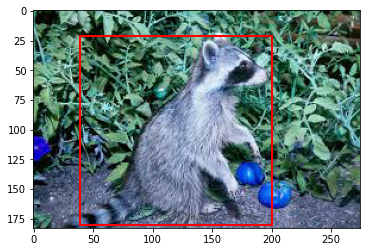

In [175]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [176]:
# create an empty image
img = tf.zeros([1, 3, 3, 3])
# draw a box around the image
box = np.array([0, 0, 1, 1])
boxes = box.reshape([1, 1, 4])
# alternate between red and blue
colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])
tf.image.draw_bounding_boxes(img, boxes, colors)


<tf.Tensor: shape=(1, 3, 3, 3), dtype=float32, numpy=
array([[[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]]], dtype=float32)>

That's All Folks !!!